## Will Millennials Ever Get Married?

This notebook contains analysis related to a paper on marriage patterns in the U.S., based on data from the National Survey of Family Growth (NSFG).

It is based on Chapter 13 of Think Stats, 2nd Edition, by Allen Downey, available from [thinkstats2.com](http://thinkstats2.com)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import math

import matplotlib.pyplot as plt
from matplotlib import pylab

from scipy.interpolate import interp1d
from scipy.misc import derivative

import thinkstats2
import thinkplot
from thinkstats2 import Cdf

import survival
import marriage

In [2]:
%time df = pd.read_hdf('FemMarriageData.hdf', 'FemMarriageData')
df.shape

CPU times: user 176 ms, sys: 24 ms, total: 200 ms
Wall time: 199 ms


(64042, 41)

Make a table showing the number of respondents in each cycle:

In [3]:
df.cycle.value_counts().sort_index()

3      7969
4      8450
5     10847
6      7643
7     12279
8      5601
9      5699
10     5554
Name: cycle, dtype: int64

In [4]:
def SummarizeCycle(df):
    ages = df.age.min(), df.age.max()
    ages= np.array(ages)
    
    intvws = df.cmintvw.min(), df.cmintvw.max()
    intvws = np.array(intvws) / 12 + 1900
    
    births = df.cmbirth.min(), df.cmbirth.max()
    births = np.array(births) / 12 + 1900

    print('# & ', intvws.astype(int), '&', len(df), '&', births.astype(int), r'\\')

In [5]:
for cycle, group in df.groupby('cycle'):
    SummarizeCycle(group)

# &  [1982 1983] & 7969 & [1937 1968] \\
# &  [1988 1988] & 8450 & [1943 1973] \\
# &  [1995 1995] & 10847 & [1950 1980] \\
# &  [2002 2003] & 7643 & [1957 1988] \\
# &  [2006 2010] & 12279 & [1961 1995] \\
# &  [2011 2013] & 5601 & [1966 1998] \\
# &  [2013 2015] & 5699 & [1968 2000] \\
# &  [2015 2017] & 5554 & [1966 2002] \\


Check for missing values in `agemarry`:

In [6]:
def CheckAgeVars(df):
    print(sum(df[df.evrmarry].agemarry.isnull()))
    
for cycle, group in df.groupby('cycle'):
    CheckAgeVars(group)

0
22
0
37
16
17
11
0


Generate a table with the number of respondents in each cohort:

In [7]:
marriage.DigitizeResp(df)
grouped = df.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

30 & 325 & 42 -- 45 & 310 & 0 \\
40 & 3608 & 32 -- 45 & 3287 & 9 \\
50 & 10631 & 22 -- 45 & 8667 & 18 \\
60 & 14951 & 15 -- 50 & 8813 & 33 \\
70 & 15016 & 14 -- 47 & 8075 & 30 \\
80 & 12397 & 14 -- 37 & 4208 & 13 \\
90 & 6695 & 15 -- 27 & 517 & 0 \\
100 & 419 & 15 -- 17 & 0 & 0 \\


In [8]:
def ComputeCutoffs(df):
    grouped = df.groupby('birth_index')
    cutoffs = {}
    for name, group in sorted(grouped):
        cutoffs[name] = int(group.age.max())
    return cutoffs

In [9]:
cutoffs = ComputeCutoffs(df)
cutoffs

{30: 45, 40: 45, 50: 45, 60: 50, 70: 47, 80: 37, 90: 27, 100: 17}

Estimate the hazard function for the 80s cohort (curious to see what's going on during the "marriage strike")

In [10]:
cohort = grouped.get_group(80)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	12384	1	0	8.1e-05
11	12383	1	0	8.1e-05
12	12382	1	0	8.1e-05
13	12381	10	0	0.00081
14	12371	12	14	0.00097
15	12345	40	260	0.0032
16	12045	104	242	0.0086
17	11699	152	338	0.013
18	11209	345	460	0.031
19	10404	436	569	0.042
20	9399	440	579	0.047
21	8380	426	572	0.051
22	7382	452	572	0.061
23	6358	383	454	0.06
24	5521	370	533	0.067
25	4618	317	576	0.069
26	3725	233	554	0.063
27	2938	167	506	0.057
28	2265	128	423	0.057
29	1714	76	391	0.044
30	1247	44	280	0.035
31	923	34	261	0.037
32	628	10	222	0.016
33	396	9	144	0.023
34	243	2	101	0.0082
35	140	1	72	0.0071
36	67	1	51	0.015
37	15	0	15	0


Run the same analysis for the 70s cohort (to extract $\lambda(33)$).

In [11]:
cohort = grouped.get_group(70)
missing = (cohort.evrmarry & cohort.agemarry.isnull())
cohort = cohort[~missing]
complete = cohort[cohort.evrmarry].agemarry_index
ongoing = cohort[~cohort.evrmarry].age_index
hf = survival.EstimateHazardFunction(complete, ongoing, verbose=True)

10	14986	2	0	0.00013
11	14984	1	0	6.7e-05
12	14983	4	0	0.00027
13	14979	11	0	0.00073
14	14968	38	3	0.0025
15	14927	81	388	0.0054
16	14458	181	518	0.013
17	13759	275	540	0.02
18	12944	562	340	0.043
19	12042	656	268	0.054
20	11118	635	242	0.057
21	10241	672	220	0.066
22	9349	702	264	0.075
23	8383	673	347	0.08
24	7363	611	345	0.083
25	6407	538	205	0.084
26	5664	481	149	0.085
27	5034	359	164	0.071
28	4511	373	198	0.083
29	3940	294	215	0.075
30	3431	235	315	0.068
31	2881	158	278	0.055
32	2445	138	212	0.056
33	2095	97	155	0.046
34	1843	78	173	0.042
35	1592	61	216	0.038
36	1315	34	203	0.026
37	1078	30	186	0.028
38	862	19	169	0.022
39	674	15	142	0.022
40	517	11	103	0.021
41	403	6	104	0.015
42	293	8	90	0.027
43	195	3	77	0.015
44	115	2	53	0.017
45	60	1	28	0.017
46	31	0	21	0
47	10	0	10	0


Use the 30s cohort to demonstrate the simple way to do survival analysis, by computing the survival function directly.

[0.99384615 0.96923077 0.94769231 0.90153846 0.81846154 0.68615385
 0.56       0.46461538 0.36307692 0.29538462 0.26153846 0.23384615
 0.21230769 0.17538462 0.14769231 0.13230769 0.11076923 0.10153846
 0.08923077 0.07692308 0.07384615 0.06461538 0.06153846 0.05846154
 0.05538462 0.04923077 0.04615385 0.        ]


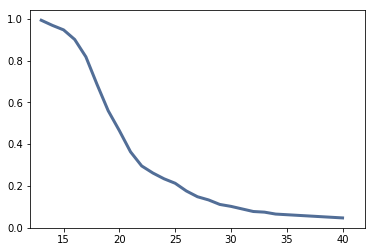

In [12]:
cohort = grouped.get_group(30)
sf = survival.MakeSurvivalFromSeq(cohort.agemarry_index.fillna(np.inf))
ts, ss = sf.Render()
print(ss)
thinkplot.Plot(ts, ss)
thinkplot.Config(xlim=[12, 42])

Then use the SurvivalFunction to compute the HazardFunction:

[0.00615385 0.0247678  0.02222222 0.0487013  0.09215017 0.16165414
 0.1838565  0.17032967 0.21854305 0.18644068 0.11458333 0.10588235
 0.09210526 0.17391304 0.15789474 0.10416667 0.1627907  0.08333333
 0.12121212 0.13793103 0.04       0.125      0.04761905 0.05
 0.05263158 0.11111111 0.0625     1.        ]


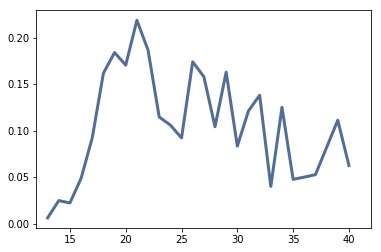

In [13]:
hf = sf.MakeHazardFunction()
ts, lams = hf.Render()
print(lams)
thinkplot.Plot(ts, lams)
thinkplot.Config(xlim=[12, 42])

Make the first figure, showing sf and hf for the 30s cohort:

In [14]:
options = dict(formats=['pdf', 'png'], clf=False)

Writing marriage1.pdf
Writing marriage1.png


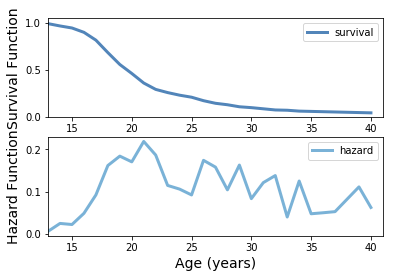

In [15]:
thinkplot.PrePlot(2, rows=2)

thinkplot.Plot(sf, label='survival')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.ylabel('Survival Function', fontsize=14)

thinkplot.SubPlot(2)
thinkplot.Plot(hf, label='hazard')
thinkplot.Config(xlabel='age(years)', ylabel='Hazard function', xlim=[13, 41])
plt.ylabel('Hazard Function', fontsize=14)
plt.xlabel('Age (years)', fontsize=14)

thinkplot.Save(root='marriage1', **options)

Writing marriage2.pdf
Writing marriage2.png


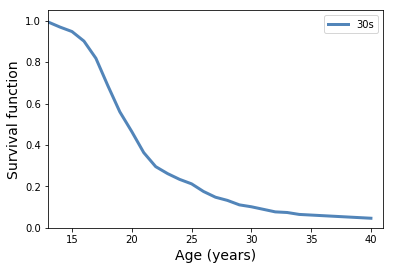

In [16]:
thinkplot.PrePlot(1)

thinkplot.Plot(sf, label='30s')
thinkplot.Config(xlim=[13, 41], ylim=[0, 1.05])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Survival function', fontsize=14)

thinkplot.Save(root='marriage2', **options)

Writing marriage3.pdf
Writing marriage3.png


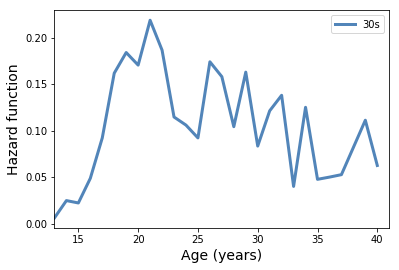

In [17]:
thinkplot.PrePlot(1)

thinkplot.Plot(hf, label='30s')
thinkplot.Config(xlim=[13, 41])
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Hazard function', fontsize=14)

thinkplot.Save(root='marriage3', **options)

Make some pivot tables, just to see where the data are:

In [18]:
pt = df.pivot_table(index='birth_index', columns='age_index', values='age', aggfunc=len, fill_value=0)
pt

age_index,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,...,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,0,0,0,0,0,0,0,...,0,19,146,148,12,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,414,384,194,198,25,0,0,0,0,0
50,0,0,0,0,0,0,0,0,42,301,...,371,482,633,533,38,0,0,0,0,0
60,0,269,300,370,665,722,609,513,520,242,...,562,537,512,517,33,18,83,153,137,2
70,3,389,523,549,362,293,283,285,365,572,...,430,363,332,241,129,116,38,0,0,0
80,14,260,242,340,483,589,658,683,705,602,...,0,0,0,0,0,0,0,0,0,0
90,0,749,829,895,888,737,452,514,465,392,...,0,0,0,0,0,0,0,0,0,0
100,0,181,171,67,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The following pivot table is not as helpful as it could be, since it doesn't show the number at risk.

In [19]:
df.pivot_table(index='birth_index', columns='agemarry_index', values='age', aggfunc=len, fill_value=0)

agemarry_index,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,...,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0
birth_index,,,,,,,,,,,,,,,,,,,,,
30,0,0,0,2,8,7,15,27,43,41,...,0,2,1,0,0,0,0,0,0,0
40,1,0,0,5,31,87,163,218,425,467,...,3,9,3,1,0,0,0,0,0,0
50,0,0,1,10,50,125,384,642,1111,1057,...,12,11,7,4,4,4,0,0,0,0
60,0,1,2,8,40,128,300,445,860,831,...,24,24,18,13,11,5,2,3,1,1
70,2,1,4,11,38,81,181,276,562,656,...,19,15,11,6,8,3,2,1,0,0
80,1,1,1,10,12,40,104,152,345,436,...,0,0,0,0,0,0,0,0,0,0
90,0,0,0,0,2,6,15,49,86,92,...,0,0,0,0,0,0,0,0,0,0


Estimate the survival curve for each cohort:

In [20]:
df['complete'] = df.evrmarry
df['complete_var'] = df.agemarry_index
df['ongoing_var'] = df.age_index
df['complete_missing'] = df.complete & df.complete_var.isnull()
df['ongoing_missing'] = ~df.complete & df.ongoing_var.isnull()

In [21]:
# for some marriages, we don't have the date of marriage

for cycle, group in df.groupby('cycle'):
    print(sum(group.complete_missing), sum(group.ongoing_missing))

0 0
22 0
0 0
37 0
16 0
17 0
11 0
0 0


In [22]:
resps = [group for cycle, group in df.groupby('cycle')]

In [23]:
%time sf_map = marriage.EstimateSurvivalByCohort(resps, iters=31, cutoffs=cutoffs)
del sf_map[30]
del sf_map[100]

CPU times: user 9.37 s, sys: 10.3 s, total: 19.7 s
Wall time: 5.1 s


Check a sample:

In [24]:
for sf in sf_map[90]:
    print(sf.ss)
    print(sf.Prob(34))
    break

14.0    0.999839
15.0    0.999354
16.0    0.996094
17.0    0.987206
18.0    0.967973
19.0    0.938156
20.0    0.904584
21.0    0.873456
22.0    0.827823
23.0    0.790639
24.0    0.763971
25.0    0.758291
26.0    0.758291
dtype: float64
0.758290917913284


In [25]:
for sf in sf_map[80]:
    print(sf.ss)
    print(sf.Prob(34))
    break

10.0    0.999916
11.0    0.999832
13.0    0.999413
14.0    0.998323
15.0    0.993955
16.0    0.986298
17.0    0.973974
18.0    0.943730
19.0    0.901592
20.0    0.861724
21.0    0.813009
22.0    0.754887
23.0    0.703596
24.0    0.652827
25.0    0.593152
26.0    0.535425
27.0    0.487718
28.0    0.452957
29.0    0.431060
30.0    0.415618
31.0    0.398546
32.0    0.391058
33.0    0.371505
34.0    0.371505
35.0    0.371505
36.0    0.371505
dtype: float64
0.37150480771615874


Make the figure showing estimated survival curves:

In [26]:
def PlotSurvivalFunctions(root, sf_map, sf_map_pred=None, **options):

    if sf_map_pred:
        marriage.PlotSurvivalFunctions(sf_map_pred, predict_flag=True)
    marriage.PlotSurvivalFunctions(sf_map)

    thinkplot.Config(xlim=[13, 50], ylim=[0, 1.05])
    thinkplot.Save(root=root, **options)

Writing marriage4.pdf
Writing marriage4.png


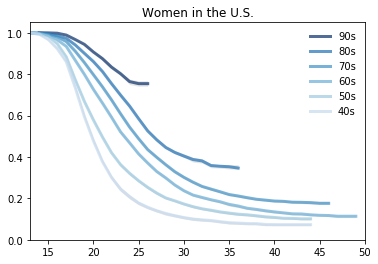

In [27]:
options_w = dict(formats=['pdf', 'png'], clf=False, title='Women in the U.S.', frameon=False)
PlotSurvivalFunctions('marriage4', sf_map, None, **options_w)

Make a table of marriage rates for each cohort at each age:

In [28]:
def MakeTable(sf_map, ages):
    t = []
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        t.append((name, vals))
    return t

In [29]:
def MakePercentageTable(sf_map, ages):
    t = MakeTable(sf_map, ages)
    for name, sf_seq in sorted(sf_map.items()):
        ts, ss = marriage.MakeSurvivalCI(sf_seq, [50])
        ss = ss[0]
        vals = [np.interp(age, ts, ss, right=np.nan) for age in ages]
        print(name, '&', ' & '.join('%0.0f' % (val*100) for val in vals), r'\\')
        
MakePercentageTable(sf_map, ages=[23, 33, 43])

40 & 24 & 9 & 7 \\
50 & 36 & 14 & 10 \\
60 & 52 & 19 & 12 \\
70 & 61 & 24 & 18 \\
80 & 70 & 36 & nan \\
90 & 80 & nan & nan \\


Generate projections:

In [30]:
%time sf_map_pred = marriage.EstimateSurvivalByCohort(resps, iters=11, cutoffs=cutoffs, predict_flag=True)
del sf_map_pred[30]
del sf_map_pred[100]

CPU times: user 3.3 s, sys: 3.99 s, total: 7.29 s
Wall time: 1.96 s


And make the figure showing projections:

Writing marriage5.pdf
Writing marriage5.png


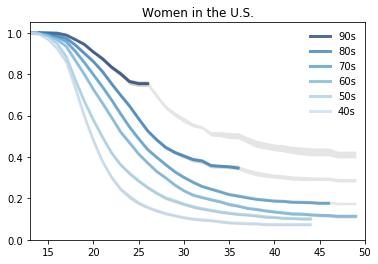

In [31]:
PlotSurvivalFunctions('marriage5', sf_map, sf_map_pred, **options_w)

Make the table again with the projections filled in.

In [34]:
ages = [43, 33, 23]
MakePercentageTable(sf_map_pred, ages)

40 & 7 & 9 & 25 \\
50 & 10 & 14 & 36 \\
60 & 12 & 19 & 52 \\
70 & 18 & 24 & 61 \\
80 & 30 & 36 & 70 \\
90 & 43 & 52 & 80 \\


In [35]:
def PlotFractions(sf_map, ages, label_flag=False, **options):
    t = MakeTable(sf_map, ages)
    cohorts, cols = zip(*t)
    rows = zip(*cols)

    thinkplot.PrePlot(3)
    t = list(zip(ages, rows))
    for age, row in reversed(t):
        label = 'at age %d' % age if label_flag else ''
        thinkplot.Plot(cohorts, row, label=label, **options)

Writing marriage6.pdf
Writing marriage6.png


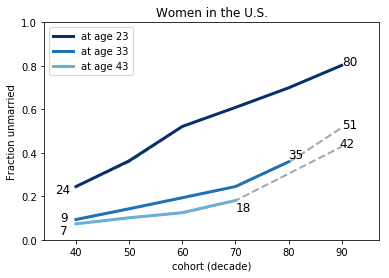

In [36]:
PlotFractions(sf_map_pred, ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map, ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(36, 0.26, '24', fontsize=fontsize)
thinkplot.Text(37, 0.13, '9', fontsize=fontsize)
thinkplot.Text(37, 0.07, '7', fontsize=fontsize)

thinkplot.Text(90, 0.85, '80', fontsize=fontsize)
thinkplot.Text(90, 0.56, '51', fontsize=fontsize)
thinkplot.Text(89.5, 0.47, '42', fontsize=fontsize)

thinkplot.Text(80, 0.42, '35', fontsize=fontsize)
thinkplot.Text(70, 0.18, '18', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='upper left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Women in the U.S.')

thinkplot.Save(root='marriage6', **options)

In [ ]:
stop

## Marriage patterns for men

In [ ]:
usecols = ['caseid', 'mardat01', 'cmdivw', 'cmbirth', 'cmintvw',
               'evrmarry', 'wgt2013_2015',
               'marend01', 'rmarital', 'fmarno', 'mar1diss']

df = marriage.ReadResp('2013_2015_MaleSetup.dct',
                  '2013_2015_MaleData.dat.gz',
                  usecols=usecols)

df['evrmarry'] = (df.evrmarry == 1)
df['divorced'] = (df.marend01 == 1)
df['divsep'] = (df.marend01 == 1) | (df.marend01 == 2)
df['cmmarrhx'] = df.mardat01
df['finalwgt'] = df.wgt2013_2015

marriage.CleanResp(df)


In [ ]:
df.agemarry.describe()

In [ ]:
df.age.describe()

In [ ]:
df.missing.describe()

In [ ]:
df.year.describe()

In [ ]:
usecols = ['caseid', 'mardat01', 'cmintvw', 'ager', 
               'evrmarry', 'wgt2015_2017',
               'marend01', 'rmarital', 'fmarno', 'mar1diss']

df = marriage.ReadResp('2015_2017_MaleSetup.dct',
                  '2015_2017_MaleData.dat.gz',
                  usecols=usecols)

# since cmbirth and cmmarrhx are no longer included,
# we have to compute them based on other variables;
# the result can be off by up to 12 months
df['cmbirth'] = df.cmintvw - df.ager*12
df['cmmarrhx'] = (df.mardat01-1900) * 12

df['evrmarry'] = (df.evrmarry==1)
df['divorced'] = (df.marend01==1)
df['separated'] = (df.marend01==2)
df['widowed'] = (df.marend01==3)
df['stillma'] = (df.fmarno == 1) & (df.rmarital==1)

df['finalwgt'] = df.wgt2015_2017
df['cycle'] = 10

# Instead of calling CleanResp, we have to customize
#CleanResp(df)

df['agemarry'] = (df.cmmarrhx - df.cmbirth) / 12.0
df['age'] = (df.cmintvw - df.cmbirth) / 12.0

# if married, we need agemarry; if not married, we need age
df['missing'] = np.where(df.evrmarry,
                             df.agemarry.isnull(),
                             df.age.isnull())

month0 = pd.to_datetime('1899-12-15')
dates = [month0 + pd.DateOffset(months=cm)
             for cm in df.cmbirth]
df['year'] = (pd.DatetimeIndex(dates).year - 1900)

marriage.DigitizeResp(df)

In [ ]:
import marriage

male2017 = marriage.ReadMaleResp2017()
male2017.head()

In [ ]:
male2017.agemarry.describe()

In [ ]:
male2017.age.describe()

In [ ]:
male2017.missing.describe()

In [ ]:
male2017.year.describe()

In [ ]:
male2002 = marriage.ReadMaleResp2002()
male2002.head()

In [ ]:
male2010 = marriage.ReadMaleResp2010()
male2010.head()

In [ ]:
male2013 = marriage.ReadMaleResp2013()
male2013.head()

In [ ]:
male2015 = marriage.ReadMaleResp2015()
male2015.head()

In [ ]:
import pandas as pd

In [ ]:
males = [male2002, male2010, male2013, male2015, male2017]
df2 = pd.concat(males, ignore_index=True, sort=False)
len(df2)

In [ ]:
sum(df2.missing)

In [ ]:
marriage.DigitizeResp(df2)
grouped = df2.groupby('birth_index')
for name, group in iter(grouped):
    print(name, '&', len(group), '&', int(group.age.min()), '--', int(group.age_index.max()),
                '&', len(group[group.evrmarry]), '&', sum(group.missing), r'\\')

In [ ]:
cutoffs2 = ComputeCutoffs(df2)
cutoffs2

In [ ]:
for df in males:
    df['complete'] = df.evrmarry
    df['complete_var'] = df.agemarry_index
    df['ongoing_var'] = df.age_index
    df['complete_missing'] = df.complete & df.complete_var.isnull()
    df['ongoing_missing'] = ~df.complete & df.ongoing_var.isnull()
    print(sum(df.complete_missing), sum(df.ongoing_missing))

In [ ]:
%time sf_map_male = marriage.EstimateSurvivalByCohort(males, iters=21, cutoffs=cutoffs2)
del sf_map_male[100]

In [ ]:
options_m = dict(formats=['pdf', 'png'], clf=False, title='Men in the U.S.')
PlotSurvivalFunctions('marriage7', sf_map_male, None, **options_m)

In [ ]:
%time sf_map_male_pred = marriage.EstimateSurvivalByCohort(males, iters=11, cutoffs=cutoffs2, predict_flag=True)
del sf_map_male_pred[100]

In [ ]:
PlotSurvivalFunctions('marriage8', sf_map_male, sf_map_male_pred, **options_m)

In [ ]:
MakePercentageTable(sf_map_male)

In [ ]:
MakePercentageTable(sf_map_male_pred)

In [ ]:
ages = [43, 33, 23]
PlotFractions(sf_map_male_pred, ages=ages, color='gray', linestyle='dashed', linewidth=2)
PlotFractions(sf_map_male, ages=ages, label_flag=True, alpha=1)

fontsize=12
thinkplot.Text(46, 0.69, '68', fontsize=fontsize)
thinkplot.Text(46, 0.30, '26', fontsize=fontsize)
thinkplot.Text(46, 0.20, '18', fontsize=fontsize)

thinkplot.Text(70, 0.18, '19', fontsize=fontsize)

thinkplot.Text(80, 0.43, '43', fontsize=fontsize)

thinkplot.Text(90, 0.89, '86', fontsize=fontsize)
thinkplot.Text(90, 0.56, '52', fontsize=fontsize)
thinkplot.Text(90, 0.40, '38', fontsize=fontsize)

thinkplot.Config(xlim=[34, 97], ylim=[0, 1], legend=True, loc='upper left',
                 xlabel='cohort (decade)', ylabel='Fraction unmarried', 
                 title='Men in the U.S.')

thinkplot.Save(root='marriage9', **options)